<a href="https://colab.research.google.com/github/Randoot/T5/blob/main/RNN_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
# Time Series Forecasting
---
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

# mplfinance : matplotlib utilities for the visualization, and visual analysis, of financial data

In [2]:
!pip install mplfinance
!pip install opendatasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.8 MB/s eta 0:00:00


# Importing libraries

# In Python, you can use the warnings module from the standard library to control warnings, such as ignoring (suppressing) warnings or turning matching warnings into exceptions.

In [6]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
#  plotting the data like a candle stick
from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

## Loading Data

The CAC 40, or the Cotation Assistée en Continu, is a benchmark French stock market index that represents a capitalization-weighted measure of the 40 most significant values among the 100 highest market caps on the Euronext Paris (formerly known as the Paris Bourse). The dataset pertaining to CAC 40 stocks on Kaggle would typically include historical data for these stocks, valuable for conducting various types of financial analysis and modeling, such as price prediction, volatility studies, or economic impact assessments.



In [7]:
import opendatasets as od
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/bryanb/cac40-stocks-dataset/data'
# Using opendatasets let's download the data sets
od.download(dataset)

Dataset URL: https://www.kaggle.com/datasets/bryanb/cac40-stocks-dataset


100%|██████████| 3.14M/3.14M [00:00<00:00, 182MB/s]

# iloc[:,1:] will select all rows but your first column will be excluded.

In [11]:
# Reading our dataset
df = pd.read_csv('cac40-stocks-dataset/preprocessed_CAC40.csv', parse_dates=['Date'],).iloc[:, 1:]
df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


# Explorartory Data Analysis

## Preprocessing

Let's zoom in at a specific company

In [10]:
# Defining a function that will contain stocks data for a specific company
def specific_data(company, start, end):
    company_data = df[df['Name'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

In [13]:
# Selecting any random company out of our 'Name' column
company_name = random.choice(df['Name'].unique().tolist())
# Setting the start and end date
start_date=dt.datetime(2014,1,1)
end_date=dt.datetime(2020,1,1)

# Calling our function
specific_df = specific_data(company_name, start_date, end_date)

In [14]:
specific_df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
75460,Société Générale (Societe Generale,2019-12-30,31.01,31.03,31.15,31.01,890
75461,Société Générale (Societe Generale,2019-12-27,31.15,30.95,31.18,30.95,"3,537"
75462,Société Générale (Societe Generale,2019-12-23,31.52,31.08,31.52,31.08,"2,599"
75463,Société Générale (Societe Generale,2019-12-20,31.05,31.15,31.21,31.05,233
75464,Société Générale (Societe Generale,2019-12-19,30.87,30.95,30.95,30.87,200


## Visualization

Let;s convert the date column to the right format and visualize some of the time series to explore patterns and seasonality

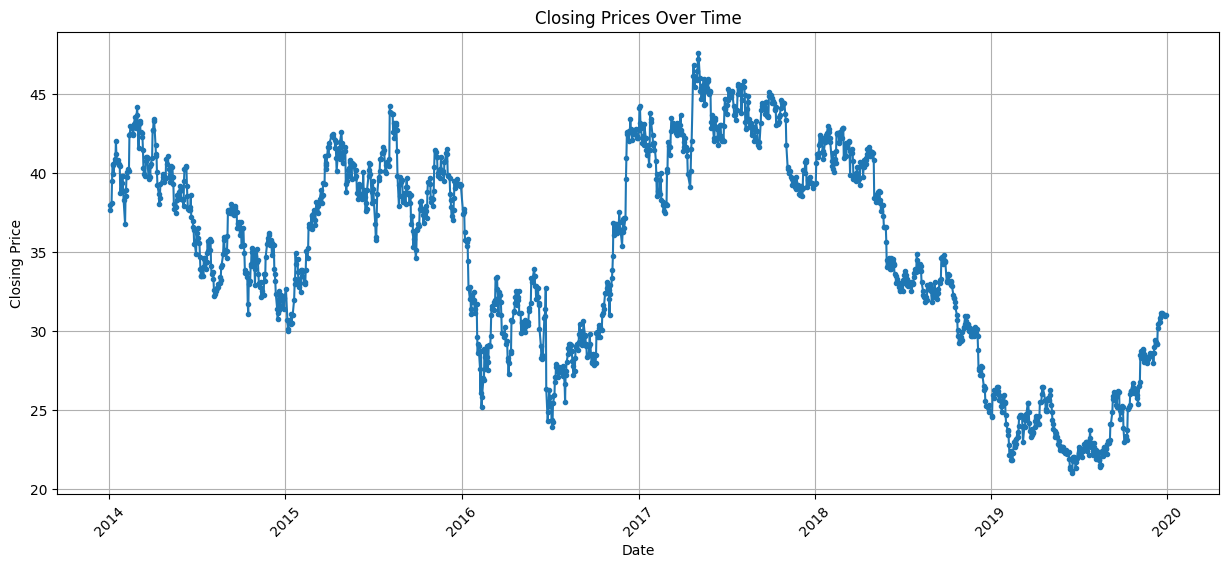

In [15]:
# Line Chart of Closing Prices Over Time

# Convert 'Date' column to datetime
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

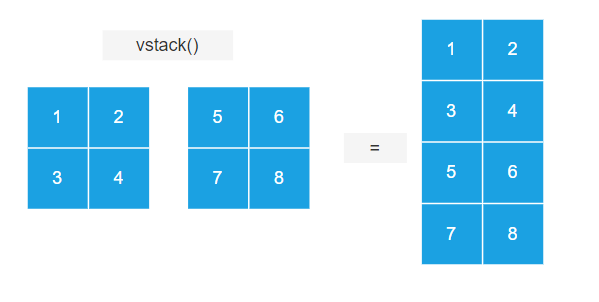

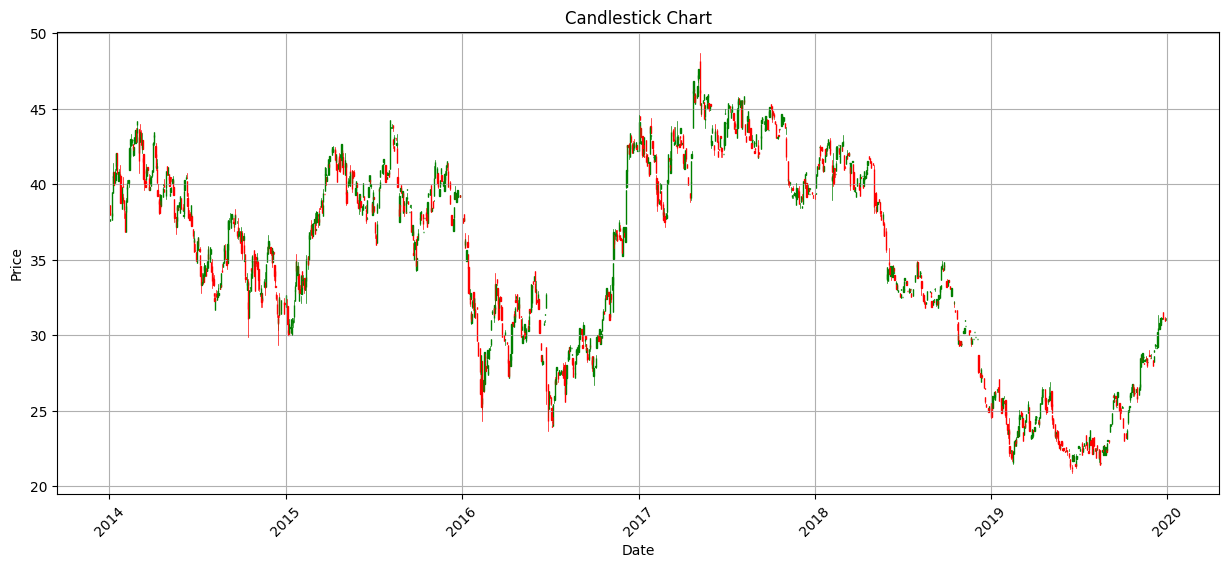

In [18]:
# Candlestick Chart

# Convert 'Date' column to matplotlib date format
matplotlib_date = mdates.date2num(specific_df['Date'])

# Create an array of tuples in the required format
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['Daily_High'], specific_df['Daily_Low'], specific_df['Closing_Price'])).T

plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45) # to make the label tilted
plt.grid(True)
plt.show()

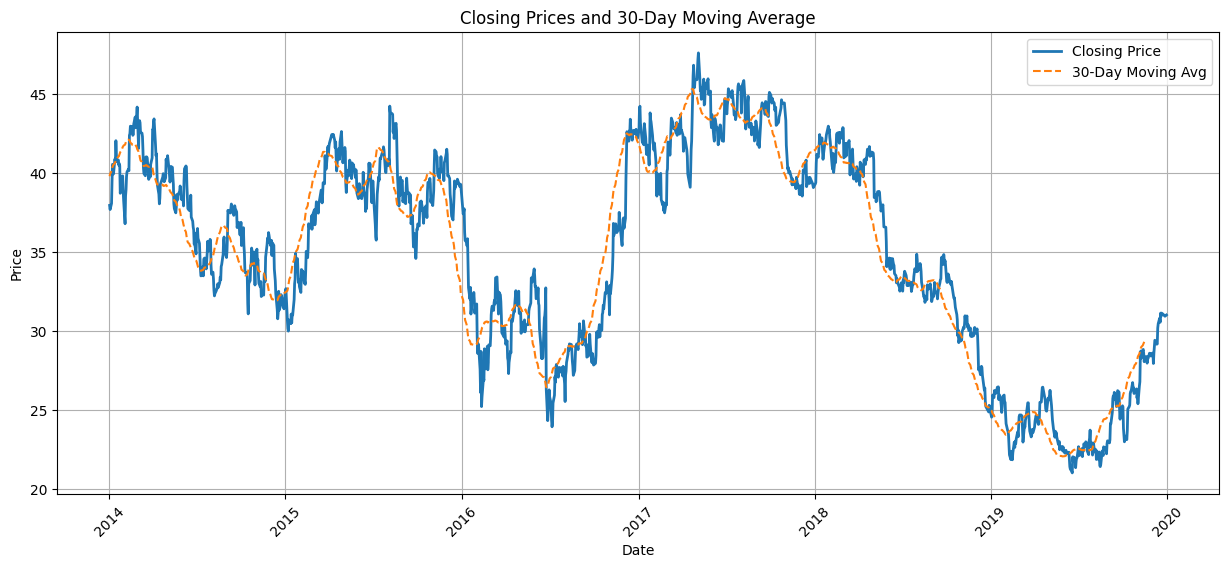

In [19]:
# Closing Prices and Moving Average plot

window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], label='Closing Price', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Closing_Price'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

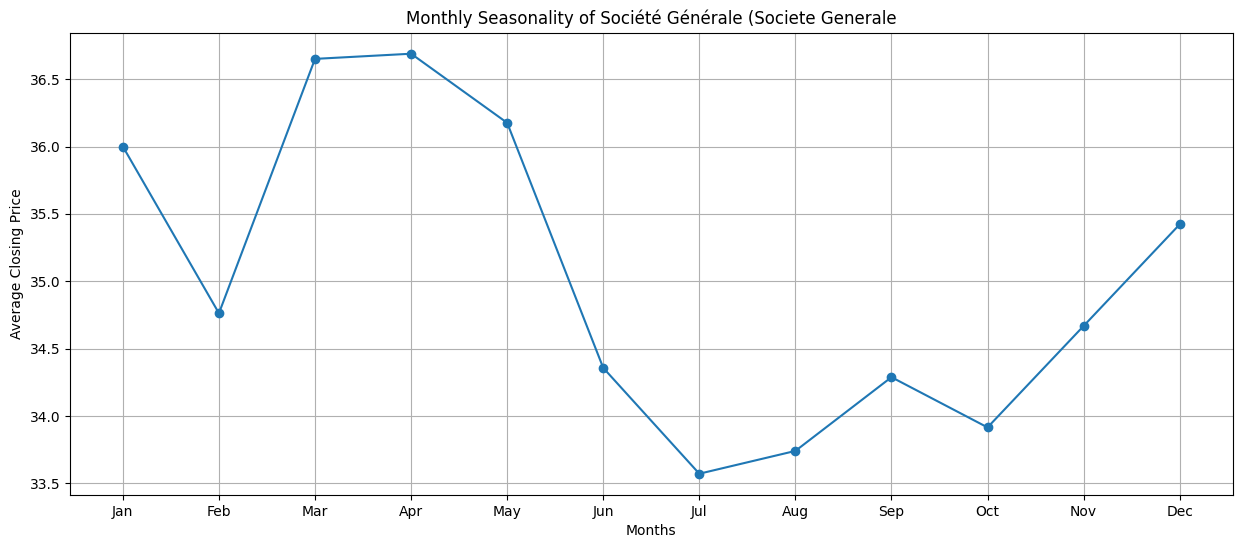

In [20]:
# Monthly Seasonality of Closing Prices
specific_df['Month'] = specific_df['Date'].dt.month

monthly_average = specific_df.groupby('Month')['Closing_Price'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {company_name}')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [21]:
new_df = specific_df.reset_index()['Closing_Price']

## Normalize the values

In [22]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [25]:
# display Scaled data

scaled_data[:5]

array([[0.37593985],
       [0.37293233],
       [0.37781955],
       [0.38045113],
       [0.37293233]])

In [43]:
scaled_data.shape

(1514, 1)

## Data Splitting
Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [26]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [40]:
train_data[:5]


array([[0.37593985],
       [0.37293233],
       [0.37781955],
       [0.38045113],
       [0.37293233]])

In [41]:
train_data.shape

(1211, 1)

# Define the window (past time steps)

>- Depending on the task and type of model you may want to generate a variety of data windows
>- A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:
![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

**In this case we will look into the past 60 steps**

In [27]:
# Define the sequence length (number of past time steps)
n_past = 60

# Prepare sequences for RNN
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [53]:
print(X_train[:1])
print(y_train[:2])

[0.15714286 0.15977444]


In [45]:
X_train.shape

(1151, 60, 1)

In [28]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1151, 60)
(1151,)


Testing set size:-
(243, 60)
(243,)


(None, None)

In [47]:
X_train.shape[0]

1151

#Samples - This is the len(data), or the amount of data points you have: 1151

Time steps - This is equivalent to the amount of time steps you run your recurrent neural network. If you want your network to have memory of 60 characters: 60.

Features - this is the amount of features in every time step. If you are processing pictures, this is the amount of pixels. In this case you seem to have 1 feature per time step: 1 D

In [46]:
# Reshape input data for RNN([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Modeling


**Recurrent Neural Networks (RNNs)** are a type of neural network particularly suited for time series data or any data where sequences matter. In time series analysis, RNNs can capture temporal dynamics because they process data sequentially while maintaining a memory (through hidden states) of previous inputs.

This memory feature of RNNs allows them to understand the entire history of a data sequence while processing each new point. This is particularly useful in applications like forecasting stock prices, predicting weather, or any scenario where the future state is dependent on previous observations. RNNs are designed to recognize patterns in sequences of data, making them effective for these kinds of predictive tasks in time series analysis.

In [32]:
# Initialize a sequential model
model = Sequential()

# First RNN layer with 50 units, input shape, and return sequences
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second RNN layer with 50 units and return sequences
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third RNN layer with 50 units
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 60, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 60, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

# optimizer= adam: optimization algorithm, to pdate network weights

In [33]:
model.compile(loss='mean_squared_error',optimizer='adam')

#Setup the revalant callbacks (Callbacks give us a great way to inject new code into training loop without touching source code of the training loop.)


>- **ModelCheckpoint:** It is used to save the model or model weights at some frequency (e.g., after every epoch) during training. It can save the best model observed during training based on a specified performance metric.
>- **earlystopping:** It allows you to stop training prematurely if a monitored metric(in this case val_loss) stops improving for a defined number of epochs. This can help prevent overfitting and reduce computational waste.

X_train: The feature matrix, where each row represents a sample and each column represents a feature.
y_train: The target vector, containing the labels or target values corresponding to the samples in X.

In [49]:
print("First element of X_train:", X_train[:1])
print("First element of y_train:", y_train[:1])

First element of X_train: [[[0.37593985]
  [0.37293233]
  [0.37781955]
  [0.38045113]
  [0.37293233]
  [0.38045113]
  [0.35864662]
  [0.36842105]
  [0.35526316]
  [0.34511278]
  [0.30714286]
  [0.30639098]
  [0.31278195]
  [0.31578947]
  [0.29962406]
  [0.28458647]
  [0.26052632]
  [0.28533835]
  [0.28421053]
  [0.27819549]
  [0.27969925]
  [0.28082707]
  [0.28496241]
  [0.27255639]
  [0.27105263]
  [0.2612782 ]
  [0.27706767]
  [0.27142857]
  [0.27669173]
  [0.26466165]
  [0.28345865]
  [0.29398496]
  [0.29210526]
  [0.27330827]
  [0.29022556]
  [0.28007519]
  [0.21691729]
  [0.20676692]
  [0.16466165]
  [0.18458647]
  [0.17857143]
  [0.2       ]
  [0.1981203 ]
  [0.1943609 ]
  [0.18909774]
  [0.20263158]
  [0.20263158]
  [0.21503759]
  [0.19511278]
  [0.19398496]
  [0.1887218 ]
  [0.16165414]
  [0.15789474]
  [0.1518797 ]
  [0.10150376]
  [0.07932331]
  [0.08233083]
  [0.08759398]
  [0.07406015]
  [0.10601504]]]
First element of y_train: [0.15714286]


In [34]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.keras', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our RNN model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])
#By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.
#verbose=0 will show you nothing (silent)
#verbose=1 will show you an animated progress bar.
#verbose=2 will just mention the number of epoch

#val_loss is the value of cost function for your cross-validation data and loss is the value of cost function for your training data.

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.4840 - val_loss: 0.0331
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.2467 - val_loss: 0.0132
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.1408 - val_loss: 0.0263
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0990 - val_loss: 0.0036
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0717 - val_loss: 0.0094
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0487 - val_loss: 0.0075
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0376 - val_loss: 0.0049
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0367 - val_loss: 0.0051
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0292 - val_loss: 0.0068
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0264 - val_loss: 0.0018
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0222 - val_loss: 0.0036
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step

In [55]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [58]:
print(train_predict[:3])

[[0.09235132]
 [0.13816406]
 [0.14823195]]


Transform the data back to it pervious form before normalization to get telling metrics using RMSE (root mean Square Error)

Reverse MinMax Scalar

In [60]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [61]:
print(train_predict[:3])

[[23.486546]
 [24.705164]
 [24.972971]]


In [63]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

34.98859691615742
36.9976651333754


https://www.statology.org/how-to-interpret-rmse/

## Visualization of results

Now let's see our output

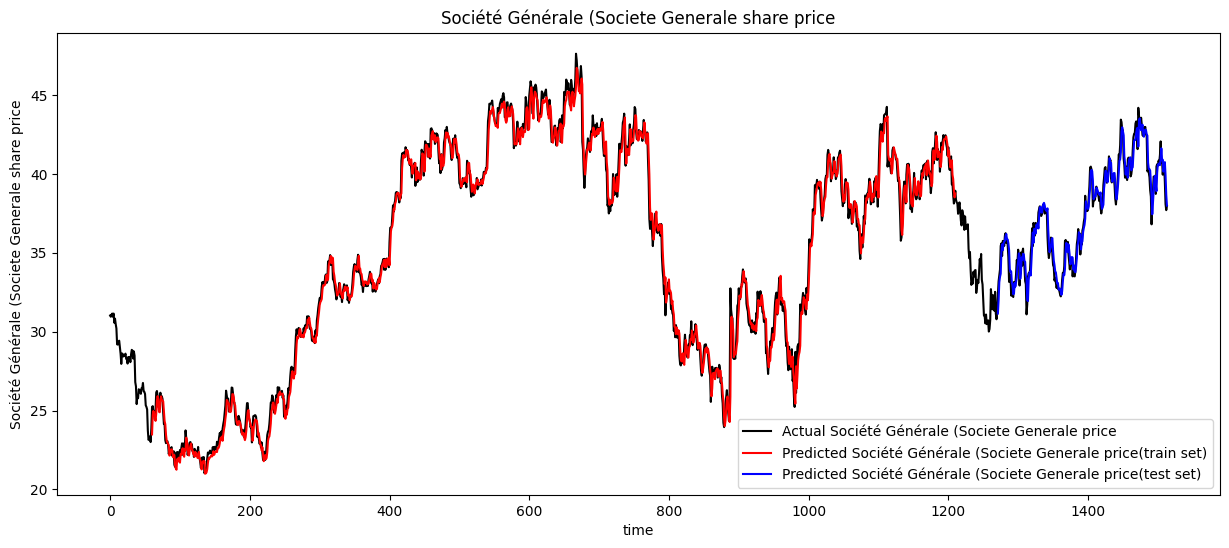

In [64]:
# Set the number of previous time steps to consider for plotting
look_back = 60

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(new_df) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {company_name} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {company_name} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {company_name} price(test set)")

plt.title(f"{company_name} share price")
plt.xlabel("time")
plt.ylabel(f"{company_name} share price")
plt.legend()
plt.show()
# Black is actual, red is predicted train data, blue is predicted test data

In [ ]:
# To predict for the next 10 days, you'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predictions for the next 10 days:
Day 1: Predicted Price = 6.288958549499512
Day 2: Predicted Price = 6.162046432495117
Day 3: Predicted Price = 5.575562953948975
Day 4: Predicted Price = 5.0206618309021
Day 5: Predicted Price = 4.547970294952393
Day 6: Predicted Price = 4.356269836425781
Day 7: Predicted Price = 3.3297793865203857
Day 8: Predicted Price = 2.771254062652588
Day 9: Predicted Price = 2.17374587059021
Day 10: Predicted Price = 1.2806715965270996


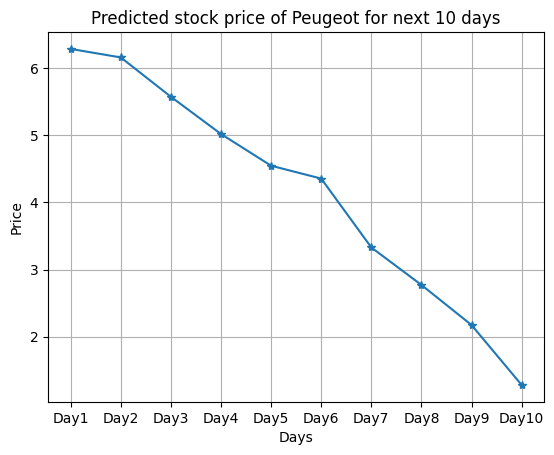

In [ ]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of {company_name} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()